In [2]:
import pandas

In [3]:
data = pandas.read_csv("data/income_data.csv")

In [4]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0


In [5]:
import statsmodels.formula.api as sma

In [8]:
model = sma.logit("target ~ sex", data=data).fit()

Optimization terminated successfully.
         Current function value: 0.526246
         Iterations 6


In [9]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: target           Pseudo R-squared: 0.047     
Date:               2023-11-20 12:43 AIC:              34274.1953
No. Observations:   32561            BIC:              34290.9771
Df Model:           1                Log-Likelihood:   -17135.   
Df Residuals:       32559            LL-Null:          -17974.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -2.0963   0.0309 -67.9249 0.0000 -2.1568 -2.0358
sex[T. Male]      1.2761   0.0342  37.3299 0.0000  1.2091  1.3431
=================================================================

"""

In [10]:
data.groupby('sex')['target'].mean()

sex
 Female    0.109461
 Male      0.305737
Name: target, dtype: float64

# Partial dependence

In [11]:
# Get a data set with lots of features ...
# ... but not too many

from sklearn.feature_selection import VarianceThreshold

In [36]:
feat = ['age', 'sex', 'occupation', 'education', 'race', 'hours-per-week']
vt = VarianceThreshold(0.15*(1-0.15))
a = vt.fit_transform(
     pandas.get_dummies(data[feat], drop_first=True))

In [39]:
X = pandas.DataFrame(a, columns=vt.get_feature_names_out())

In [40]:
X

,age,hours-per-week,sex_ Male,education_ Bachelors,education_ HS-grad,education_ Some-college
0,39,40,1,1,0,0
1,50,13,1,1,0,0
2,38,40,1,0,1,0
3,53,40,1,0,0,0
4,28,40,0,1,0,0
...,...,...,...,...,...,...
32556,27,38,0,0,0,0
32557,40,40,1,0,1,0
32558,58,40,0,0,1,0
32559,22,20,1,0,1,0


In [41]:
y = data['target']

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

In [47]:
gbc = GradientBoostingClassifier().fit(X, y)

In [48]:
from sklearn.inspection import PartialDependenceDisplay

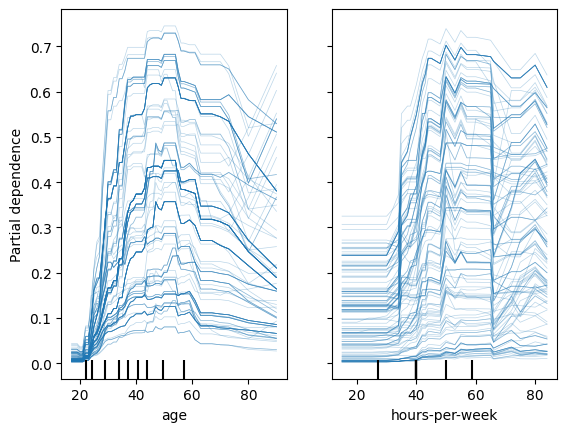

In [51]:
PartialDependenceDisplay.from_estimator(gbc, X.sample(150), ['age', 'hours-per-week'], kind='individual')

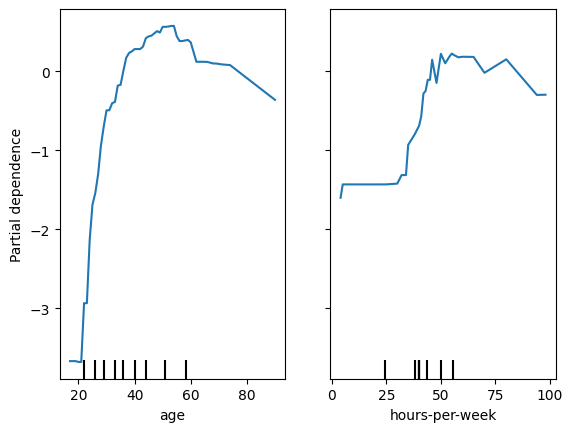

In [52]:
PartialDependenceDisplay.from_estimator(gbc, X.sample(200), ['age', 'hours-per-week'])

In [53]:
from sklearn.linear_model import LogisticRegression

In [62]:
log_reg = LogisticRegression().fit(X, y)

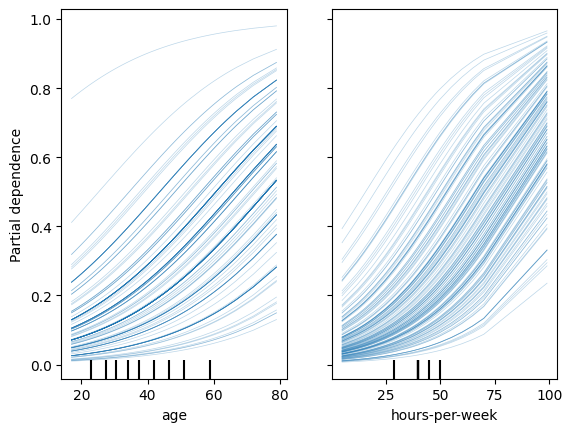

In [64]:
PartialDependenceDisplay.from_estimator(log_reg, X.sample(150), ['age', 'hours-per-week'], kind='individual')

In [66]:
from sklearn.model_selection import cross_val_score

<Axes: >

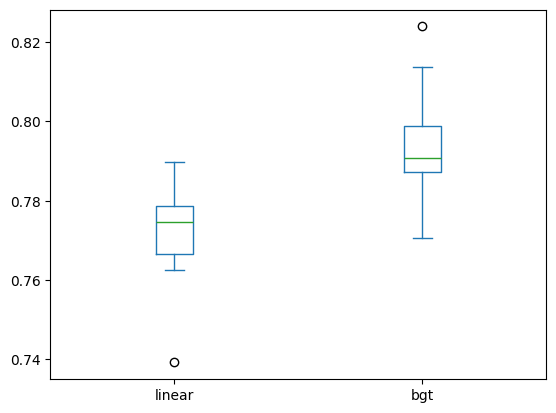

In [68]:
pandas.DataFrame(
    {'linear': cross_val_score(log_reg, X, y, cv=30),
     'bgt': cross_val_score(gbc, X, y, cv=30),                        }
).plot.box()

# Shapley Values

In [69]:
import shap

In [70]:
!python --version

Python 3.11.6


In [71]:
shap.initjs()

In [80]:
explainer = shap.Explainer(log_reg, X)
X_sample = X.sample(1_000)
shap_values = explainer(X_sample)

In [81]:
shap.force_plot(shap_values[5]) # shapley values for 5th data point form sample

In [82]:
shap.force_plot(shap_values[10]) # shapley values for 5th data point form sample

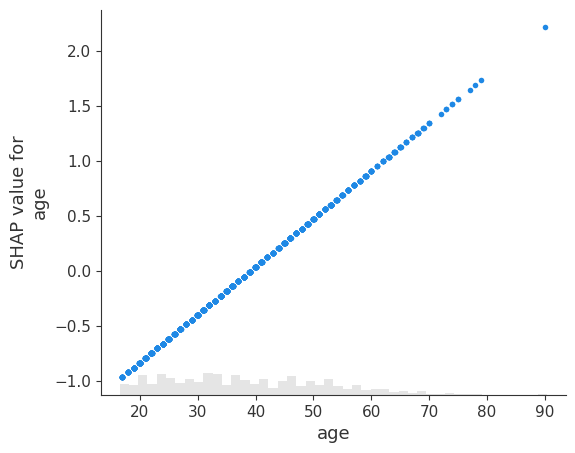

In [76]:
shap.plots.scatter(shap_values[:, 'age'])

In [83]:
gbc_explainer = shap.Explainer(gbc, X)
gbc_shap_values = gbc_explainer(X_sample)

In [84]:
shap.force_plot(gbc_shap_values[5])

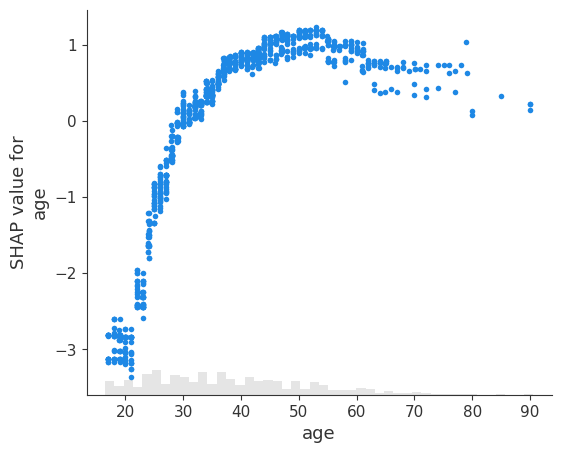

In [85]:
shap.plots.scatter(gbc_shap_values[:, 'age'])

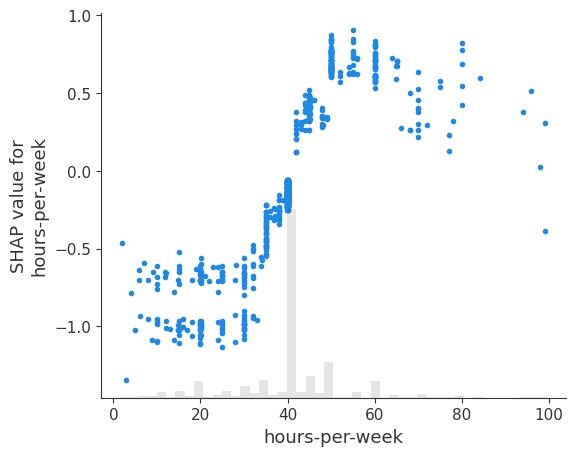

In [86]:
shap.plots.scatter(gbc_shap_values[:, 'hours-per-week'])

<Axes: xlabel='age'>

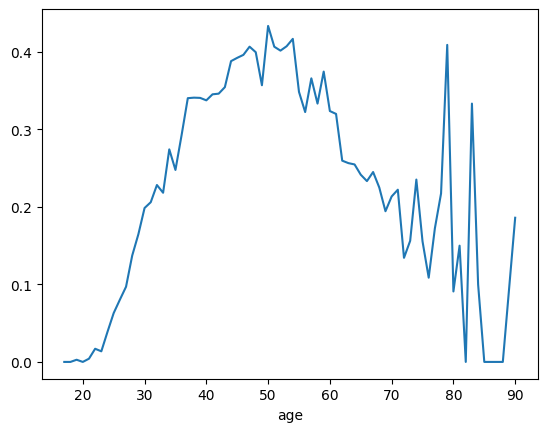

In [89]:
data.groupby('age')['target'].mean().plot.line()

# Fairness

In [90]:
from sklego.metrics import p_percent_score, equal_opportunity_score

In [92]:
X.columns

Index(['age', 'hours-per-week', 'sex_ Male', 'education_ Bachelors',
       'education_ HS-grad', 'education_ Some-college'],
      dtype='object')

In [93]:
z = 'sex_ Male'

In [99]:
p_percent_score(z)(log_reg, X, y)

0.03876233628145866

In [100]:
equal_opportunity_score(z)(log_reg, X, y)

0.036105759199191394

## What can be done to improve fairness?

- Drop z
- Drop everything correlated with z
- Adjust model thesholds